# A/B-тестирование 

### Техническое задание

- Тест: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`

### Описание

Исследуем результаты тестирования контрольной группы и новой платёжной воронки в тесте `recommender_system_test`. 
Для этого в распоряжении имеются несколько датасетов:
- `final_ab_events`, где указаны данные по событиям
- `final_ab_new_users` с информацией о новых пользователях
- `final_ab_participants` хранит данные об участниках тестов
- `ab_project_marketing_events` содержит информацию о проведении маркетинговых мероприятий
    
### План работы:

- предобработать все данные
- провести исследовательский анализ
- запустить А/В тест и расшифровать результаты
- сформулировать рекомендации

In [1]:
# импортируем библиотеки
import pandas as pd
import scipy.stats as st
import numpy as np
import math as mth
import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
# читаем файлы
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

## Предобработка данных

**Начнём с проверки таблицы событий:**

In [3]:
events.head()

user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99

In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Всего 440317 записей, со временем и названием события, а также данные по клиенту - его идентификатор и детализация.  
Видим, что не по всем пользователям она есть, только у 14% пользователей. Вероятно, это данные о покупках, когда есть информация о стоимости заказа. 

In [5]:
# проверяем название события, где нет пропусков в детализации
events[~events['details'].isna()]['event_name'].unique()

array(['purchase'], dtype=object)

Предположение подтвердилось.  

Проверим, как распределены пропуски:

In [6]:
# считаем пропуски в столбцах по каждому событию
events[events['details'].isna()].groupby('event_name').agg('count')

user_id  event_dt  details
event_name                              
login          189552    189552        0
product_cart    62462     62462        0
product_page   125563    125563        0

Больше всего пропусков при авторизации, затем просмотре страницы и потом уже добавлении в корзину.  
Предположительно, эти значения пропорциональны общему числу дошедших до каждого шага воронки. 

Оставим эти пропуски без корректировки.

Посмотрим, какие ещё события есть в таблице:

In [7]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Всего 4 типа события:
- авторизация  
- страница продукта
- корзина
- покупка 

Теперь приведём столбец с датой к нужному типу:

In [8]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
events[['event_dt']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event_dt  440317 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.4 MB


In [9]:
print(events['event_dt'].min())
print(events['event_dt'].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


Представлены события с 7 по 30 декабря 2020 года.

In [10]:
events['event_date'] = events['event_dt'].dt.date

In [11]:
events.duplicated().sum()

0

Дупликатов не обнаружено.  

**Проверим таблицу пользователей:**

In [12]:
users.head()

user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [14]:
users['user_id'].nunique()

61733

In [15]:
users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

Всего 61733 записи уникальных пользователей, без пропусков.  
Указаны идентификатор, дата регистрации, регион и тип девайса. 

Приведём столбец даты к нужному типу:

In [16]:
users['first_date'] = pd.to_datetime(users['first_date'])
users[['first_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   first_date  61733 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 482.4 KB


In [17]:
print(users['first_date'].min())
print(users['first_date'].max())

2020-12-07 00:00:00
2020-12-23 00:00:00


Данные о пользователях с 7 по 23 декабря 2020 года.  
Нам необходимо исключить пользователей, которые зарегистрировались после 21 декабря:

In [78]:
users = users[users['first_date'] <= '2020-12-21 00:00:00']
print(users['first_date'].max())

2020-12-21 00:00:00


In [20]:
users.duplicated().sum()

0

Дупликатов не обнаружено.

**Теперь проверим таблицу участников тестов:**

In [21]:
participants.head()

user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test

In [22]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


В таблице есть идентификатор пользователя, а также группа теста и его название.  
Пропусков нет.

In [23]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Согласно технического задания, тест для исследования только один.  
В таблице обнаружен другой - `interface_eu_test`  

Проверим, как пересекаются участники из разных тестов:

In [24]:
participants.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1').count()

ab_test    1602
dtype: int64

Всего 1602 пользователя, которые попали в оба теста. 
Посмотрим, как они распределены внутри групп каждого из тестов:

In [25]:
# объявляем пользователей, попавших в обе группы теста
double = participants.groupby('user_id')['ab_test'].nunique()
participants = participants.merge(double, on='user_id')

In [26]:
participants = participants.rename(columns={'ab_test_x':'ab_test', 'ab_test_y':'nunique_test'})
participants.query('nunique_test == 2').groupby(['ab_test', 'group'])['user_id'].nunique()

ab_test                  group
interface_eu_test        A        819
                         B        783
recommender_system_test  A        921
                         B        681
Name: user_id, dtype: int64

Пользователи из двух тестов распределены неравномерно по группам.  

Поскольку пользователи нашего теста оказались в другом, это могло повлиять на их поведение - поэтому удалим таких пользователей, чтобы не искажать результаты.

In [27]:
# объявляем пользователей из европы
eu_users = users.query('region == "EU"')

42340

In [28]:
# объявляем участников теста rst
rst_users = eu_users.merge(participants, on='user_id', how='right')

16666

In [29]:
# отбираем тест rst и пользователей, которые участвовали только в одном тесте
rst_users = rst_users.query('ab_test == "recommender_system_test" and nunique_test != 2')
rst_users.sample(5)

user_id first_date region   device group  \
326   1C26EEFD9070FD8A 2020-12-15     EU  Android     B   
4827  79BCCF1C768003EA 2020-12-15     EU  Android     A   
7766  514E9A2436E0C45C 2020-12-14     EU       PC     A   
7387  18AA20A353ED097E 2020-12-16     EU  Android     A   
8232  953E74FDE41424B4        NaT    NaN      NaN     A   

                      ab_test  nunique_test  
326   recommender_system_test             1  
4827  recommender_system_test             1  
7766  recommender_system_test             1  
7387  recommender_system_test             1  
8232  recommender_system_test             1

In [30]:
print('Уникальных пользователей после предобработки:', rst_users['user_id'].nunique())

Уникальных пользователей после предобработки: 5099


In [31]:
print('Доля пользователей из Европы в тесте rst:', round(
    rst_users['user_id'].nunique()/
    eu_users['user_id'].nunique() * 100, 2))

Доля пользователей из Европы в тесте rst: 12.04


После предобработки осталось 5099 участников теста.  
Это составило 12% от числа новых пользователей из Европы.   
<font color='red'>*Ни одно значение не удовлетворяет техническому заданию*<font>

Проверим, сколько пользователей попало в обе группы теста:

In [32]:
rst_users.groupby('user_id').agg({'group':'nunique'}).query('group > 1').count()

group    0
dtype: int64

Пользователей, которые попали в обе группы теста не обнаружено.

In [33]:
rst_users = (
    rst_users
    .merge(events, on='user_id', how='right')
)

In [34]:
# объявляем столбец с лайфтаймом
rst_users['lifetime'] = (rst_users['event_dt'] - rst_users['first_date']).dt.days
rst_users[['first_date', 'event_dt', 'lifetime']].sample(5)

first_date            event_dt  lifetime
223652        NaT 2020-12-23 04:05:31       NaN
412800 2020-12-07 2020-12-25 14:04:02      18.0
24070         NaT 2020-12-16 09:49:46       NaN
141225        NaT 2020-12-11 21:16:44       NaN
33513         NaT 2020-12-19 11:06:16       NaN

In [35]:
rst_users = rst_users.query('lifetime <= 13')
rst_users.shape

(16918, 12)

Исключили из анализа события, старше 14 дней. 

**Приступим к таблице с маркетинговыми событиями:**

In [36]:
marketing_events.head()

name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11

In [37]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [38]:
marketing_events['name'].nunique()

14

In [39]:
marketing_events['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

Таблица содержит 14 разных промо-кампаний в регионах - проводятся либо в одном, либо сразу в нескольких.  

Приведём столбцы с датами к нужному типу:

In [40]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
marketing_events[['start_dt', 'finish_dt']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   start_dt   14 non-null     datetime64[ns]
 1   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 352.0 bytes


Проверим пересечение проведения теста и маркетинговых кампаний:

In [41]:
# проверяем пересечение с тестом rst
marketing_events.query('start_dt >= "2020-12-07"')

name        regions   start_dt  finish_dt
0    Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03
10  CIS New Year Gift Lottery            CIS 2020-12-30 2021-01-07

Тест пересекается с двумя кампаниями:
- `Christmas&New Year Promo`
- `CIS New Year Gift Lottery`

Поскольку вторая проходит на территории Содружества независимых государств, а нам необходимо анализировать европейских пользователей, пересечение проходит только с рождественской промо-кампанией.

In [42]:
marketing_events.duplicated().sum()

0

Явных дупликатов не обнаружено.  
Можно переходить к исследовательскому анализу.

## Исследовательский анализ

Проверим, как распределены эти пользователи по группам теста:

In [43]:
# разделяем группы
sample_a = rst_users.query('group == "A"')
print('Размер группы А:', sample_a['user_id'].nunique())
print('Доля группы А:', round(sample_a['user_id'].nunique() / rst_users['user_id'].nunique() * 100, 2))
print( )
sample_b = rst_users.query('group == "B"')
print('Размер группы B:',sample_b['user_id'].nunique())
print('Доля группы B:', round(sample_b['user_id'].nunique() / rst_users['user_id'].nunique() * 100, 2))

Размер группы А: 1939
Доля группы А: 74.75

Размер группы B: 655
Доля группы B: 25.25


Группа А значительно больше группы В - почти в 3 раза.  
Такой дисбаланс в пропорциях оставим допустимым, поскольку у нас достаточно данных в обеих группах для обнаружения изменений.

Проверим, сколько всего событий приходится на одного пользователя в каждой из групп:

In [68]:
print('Среднее кол-во событий на пользователя в группе А:',
      (sample_a.groupby('user_id')['event_name'].count()).mean())
print('Медианное кол-во событий на пользователя в группе А:',
      (sample_a.groupby('user_id')['event_name'].count()).median())

Среднее кол-во событий на пользователя в группе А: 6.897369778236204
Медианное кол-во событий на пользователя в группе А: 6.0


In [69]:
print('Среднее кол-во событий на пользователя в группе B:',
      (sample_b.groupby('user_id')['event_name'].count()).mean())
print('Медианное кол-во событий на пользователя в группе B:',
      (sample_b.groupby('user_id')['event_name'].count()).median())

Среднее кол-во событий на пользователя в группе B: 5.410687022900763
Медианное кол-во событий на пользователя в группе B: 4.0


В группе А событий на пользователя больше - в среднем 6.8 против 5.4 группы В.   
Чаще пользователи совершают 6 событий в группе А и лишь 4 в группе В. 

**Посмотрим на общую динамику событий**:

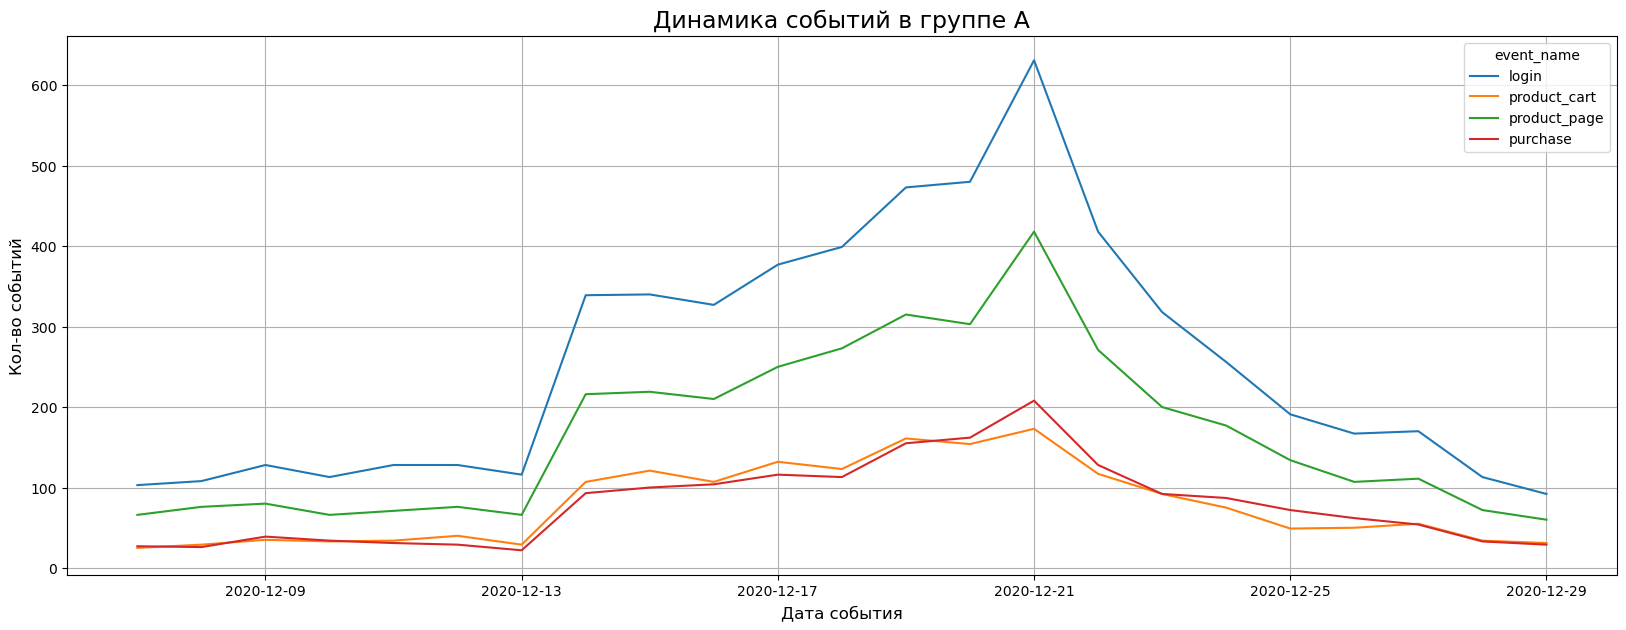

In [46]:
# визуализируем общую динамику событий в группе А
(sample_a
 .pivot_table(
     index='event_date', 
     columns='event_name', 
     values='user_id', 
     aggfunc='count')
 .plot(grid=True, figsize=(20,7))
)
plt.xlabel('Дата события', size=12)
plt.ylabel('Кол-во событий', size=12)
plt.title('Динамика событий в группе А', size=17)
plt.show()

Наиболее активный день - 21 декабря, самое популярное событие - регистрация (свыше 600).  
До 13 декабря наблюдается ровная динамика, после - резкий пик активности за один день и далее положительная динамика на неделю для всех событий.  
После 21 декабря наблюдается резкое падение активности, сохраняющееся до конца наблюдений и не превышающее отметку 100 для каждого события.

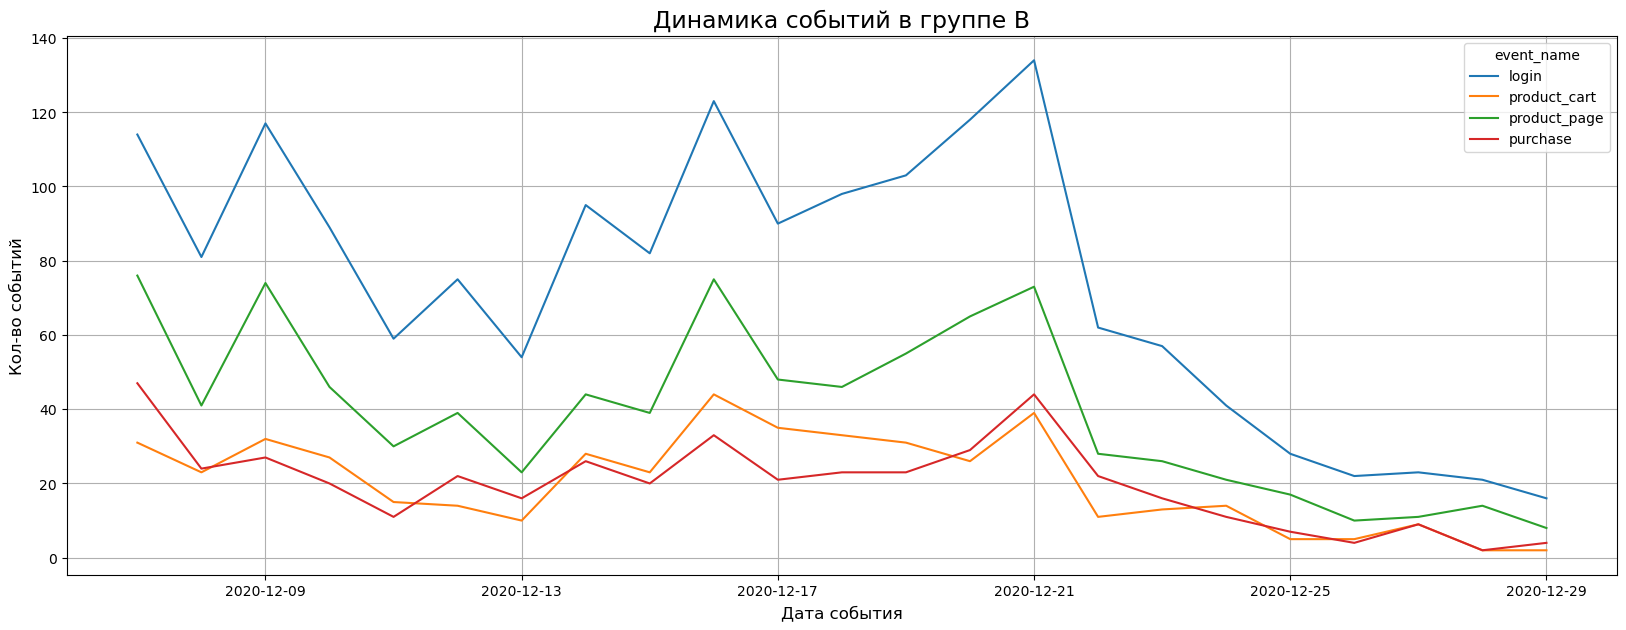

In [47]:
# визуализируем общую динамику событий в группе В
(sample_b
 .pivot_table(
     index='event_date', 
     columns='event_name', 
     values='user_id', 
     aggfunc='count')
 .plot(grid=True, figsize=(20,7))
)
plt.xlabel('Дата события', size=12)
plt.ylabel('Кол-во событий', size=12)
plt.title('Динамика событий в группе B', size=17)
plt.show()

В группе В более сложная динамика - видны резкие скачки, которые усреднённо держатся около одних значений по каждому событию (регистраций - 80, просмотров товара - 50, добавление в корзину и покупка - 30) вплоть до 21 декабря, после которого намечается отрицательная динамика по всем.   
Явный лидер - регистрация, аутсайдера выделить сложнее - добавление в корзину и покупка попеременно меняются в зависимости ото дня.  

**Посмотрим на динамику когорт в каждой группе по просмотрам страницы товара:**

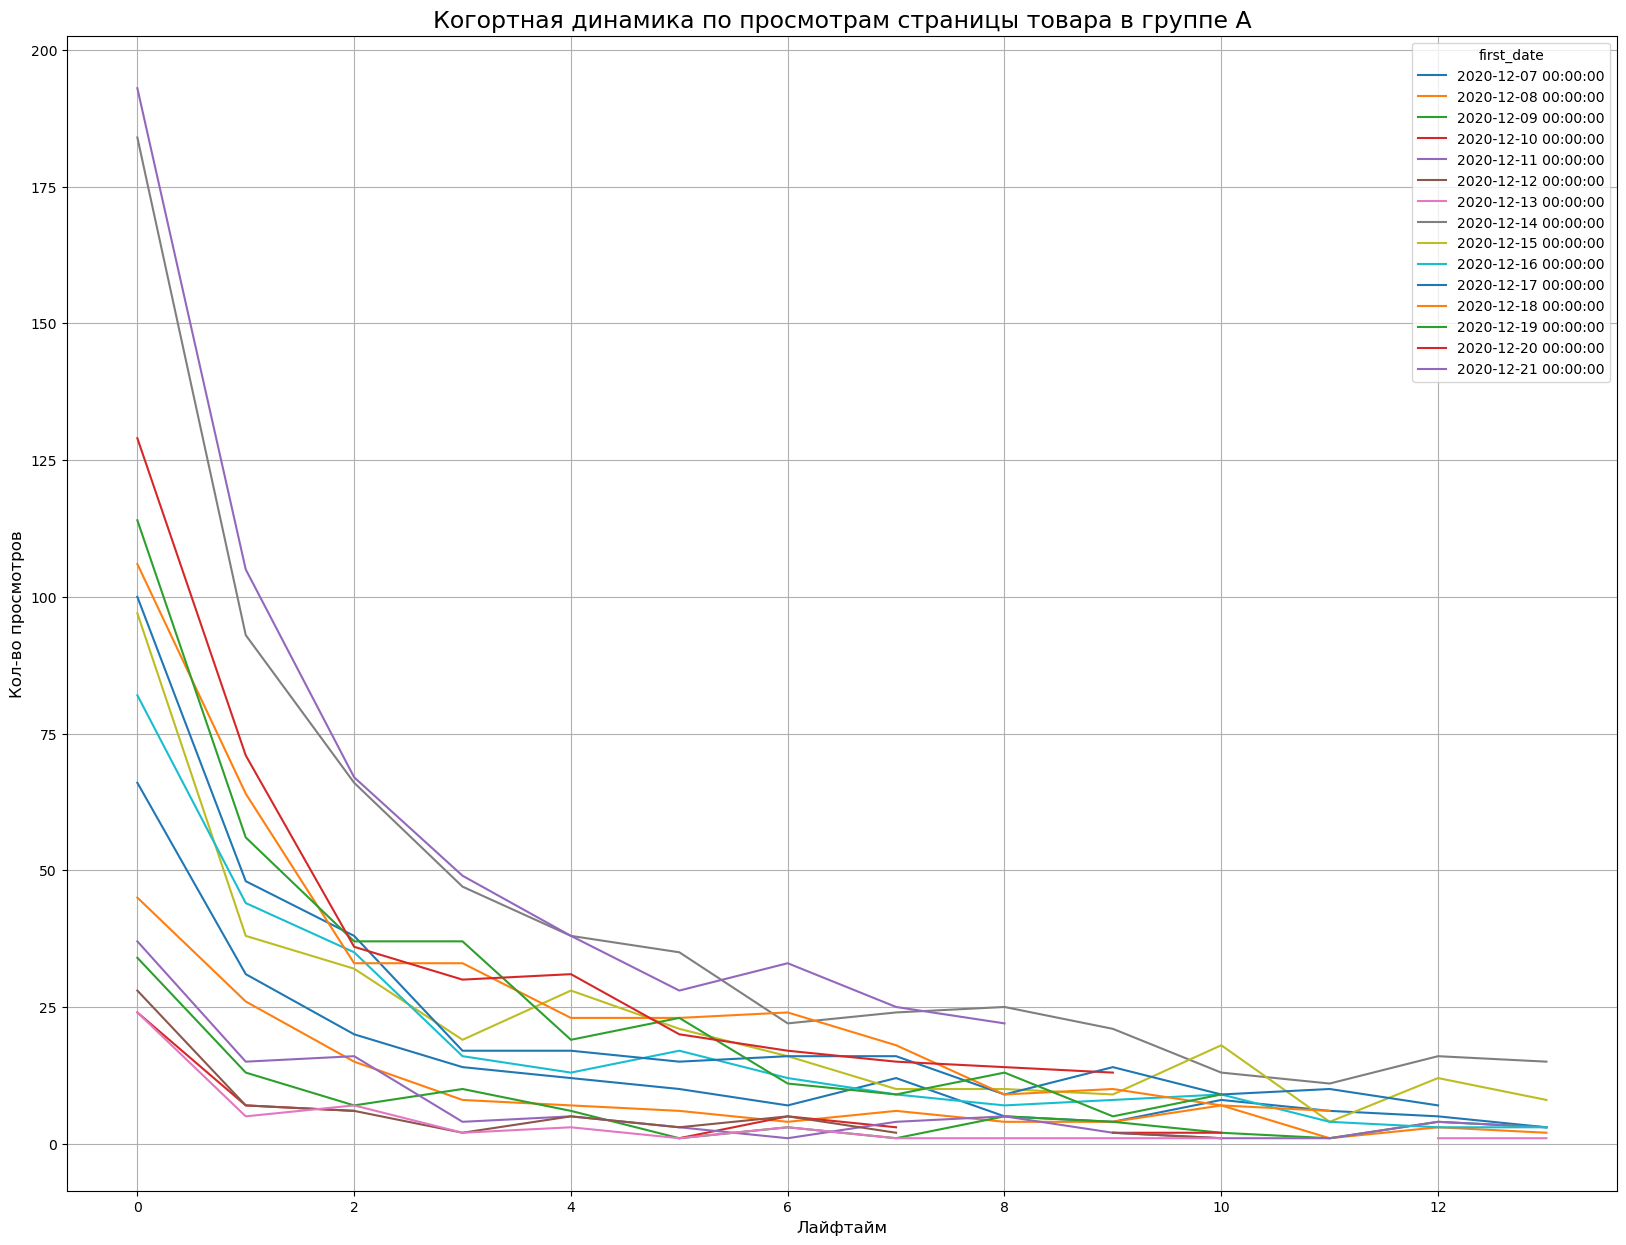

In [48]:
# визуализируем когортную динамику по просмотру товара в группе А
(sample_a
 .query('event_name == "product_page"')
 .pivot_table(
     index='lifetime', 
     columns='first_date', 
     values='user_id', 
     aggfunc='count')
 .plot(grid=True, figsize=(20,15))
)
plt.xlabel('Лайфтайм', size=12)
plt.ylabel('Кол-во просмотров', size=12)
plt.title('Когортная динамика по просмотрам страницы товара в группе А', size=17)
plt.show()

Происходит резкий спад просмотров с максимальных значений в первые три дня.   
Динамика отрицательная для всех когорт, выделить можно старт 21 декабря, это самая активная когорта (однако с неполным циклом - прожила только 9 дней).  
Немногим уступает когорта 14 декабря, она сохраняет лидерство на протяжении второй недели по числу просмотров.  
Также есть когорты, которые не имеют активности в определенные дни - так когорта 13 декабря неактивна с одиннадцатого по тринадцатый лайфтайм. 

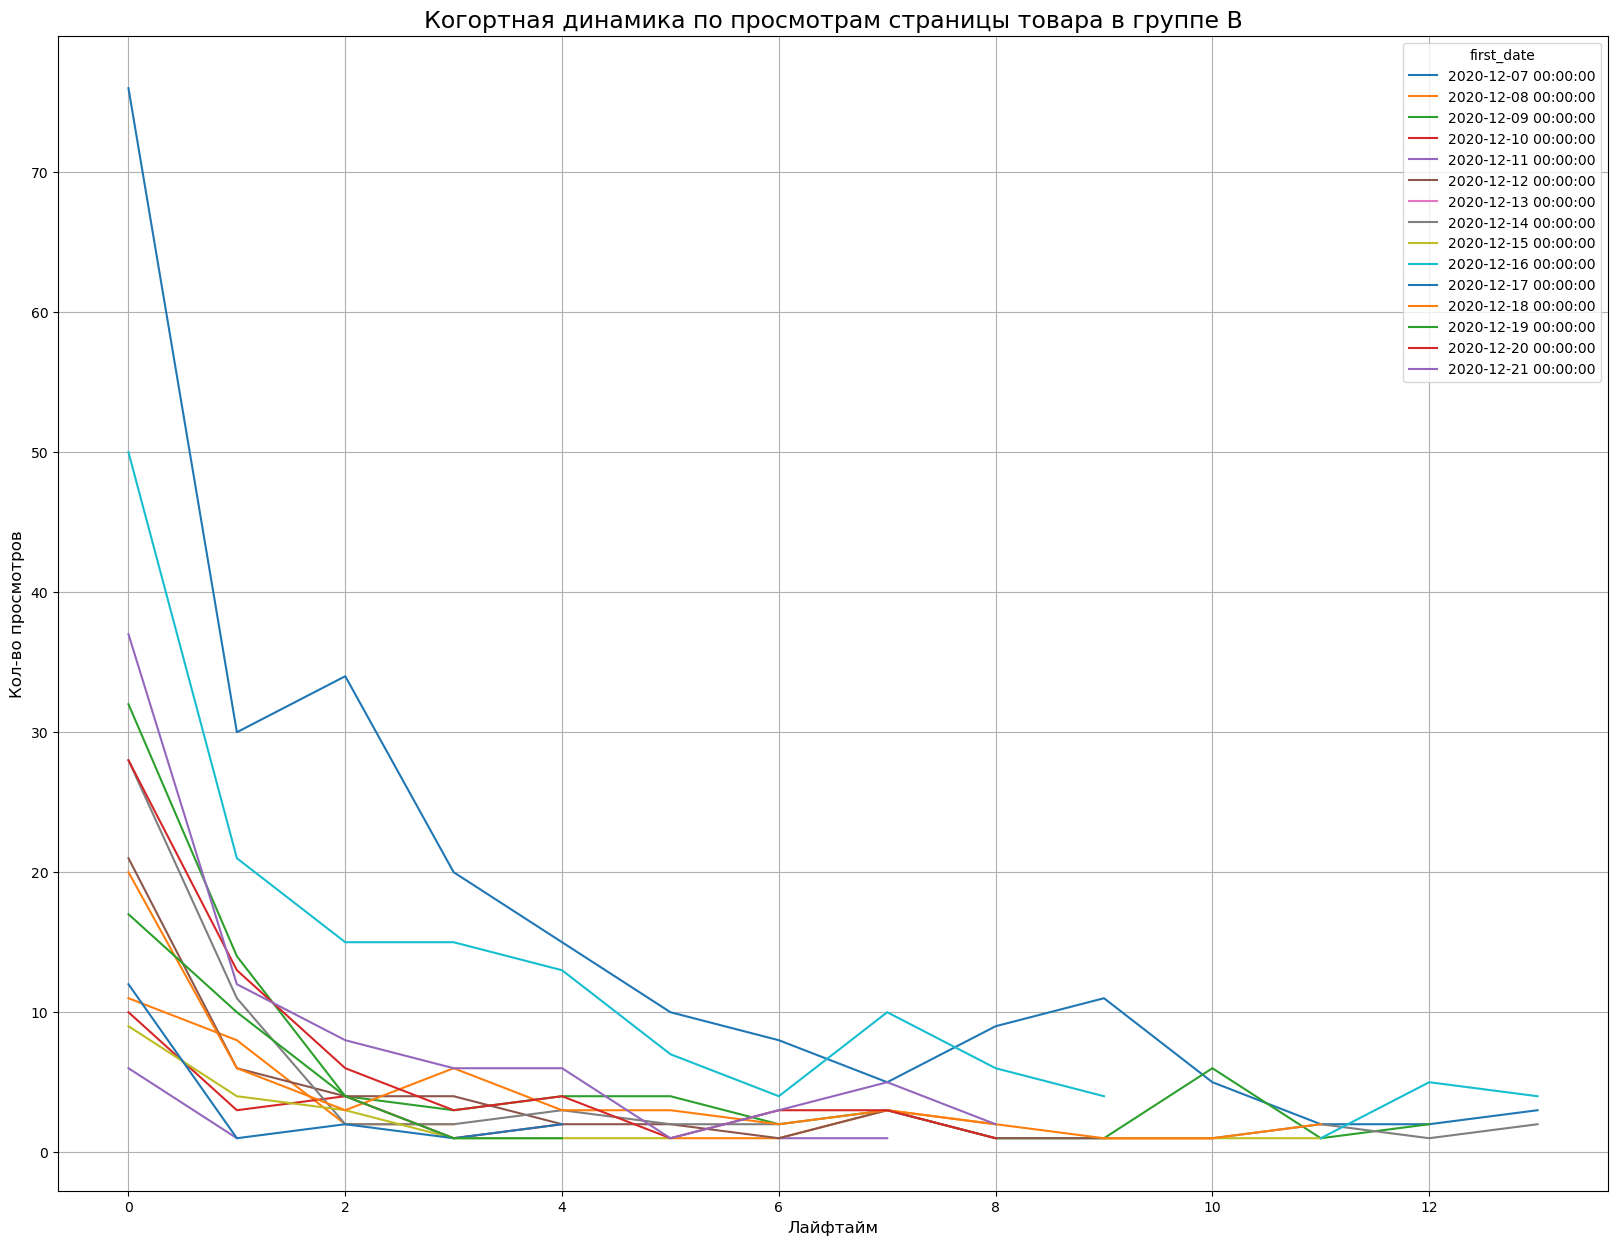

In [49]:
# визуализируем когортную динамику по просмотру товара в группе В
(sample_b
 .query('event_name == "product_page"')
 .pivot_table(
     index='lifetime', 
     columns='first_date', 
     values='user_id', 
     aggfunc='count')
 .plot(grid=True, figsize=(20,15))
)
plt.xlabel('Лайфтайм', size=12)
plt.ylabel('Кол-во просмотров', size=12)
plt.title('Когортная динамика по просмотрам страницы товара в группе В', size=17)
plt.show()

В группе В намечается лидер - когорта 17 декабря. Она занимает верхние позиции большую часть времени, незначительно уступая лишь на восьмой и четырнадцатый день (до которого доходят всего три когорты, из которых также 14 и 16 декабря).  
Большая часть когорт полностью теряет активность уже через неделю, а оставшиеся имеют ровную динамику с небольшими пиками активности:
- для когорты 16 декабря на восьмой и тринадцатый день (отметим, что есть несколько неактивных дней между)
- для когорты 19 декабря на одиннадцатый день  

**Перейдём к добавлению в корзину по группам:**

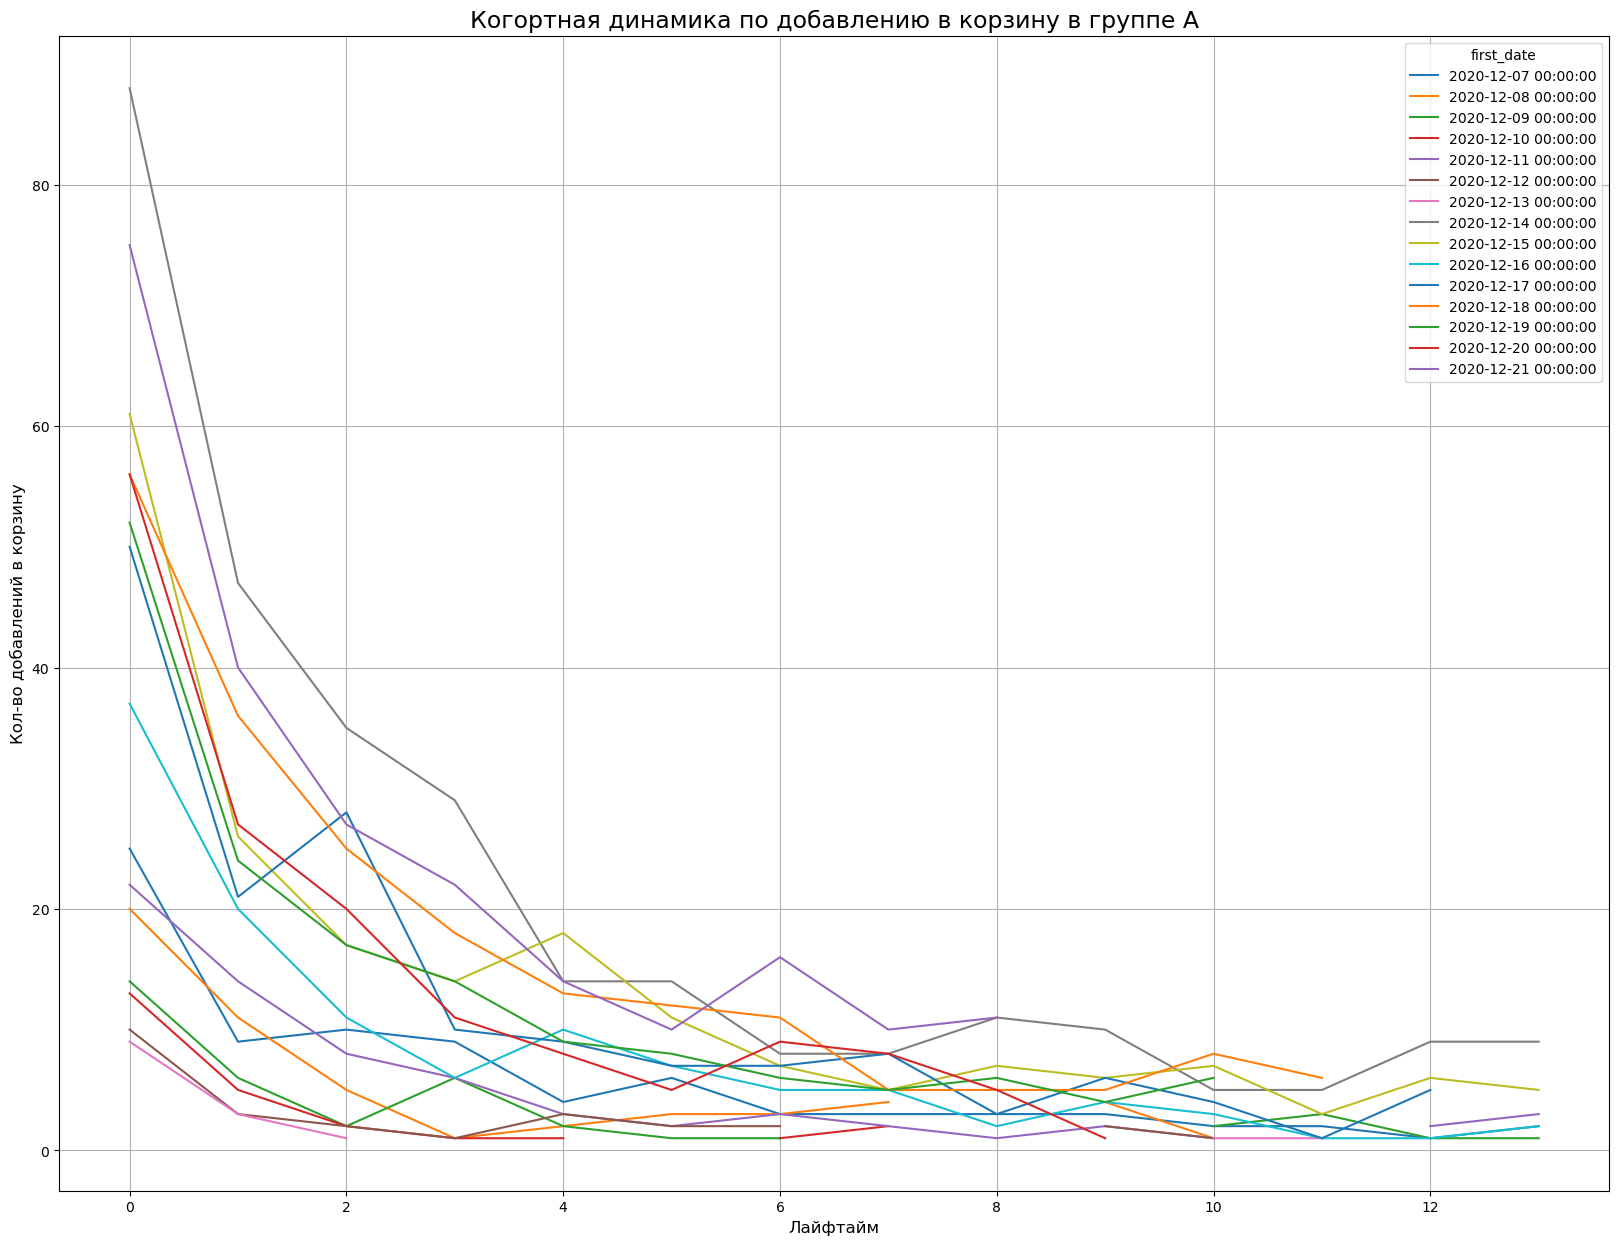

In [50]:
# визуализируем когортную динамику по добавлению в корзину в группе А
(sample_a
 .query('event_name == "product_cart"')
 .pivot_table(
     index='lifetime', 
     columns='first_date', 
     values='user_id', 
     aggfunc='count')
 .plot(grid=True, figsize=(20,15))
)
plt.xlabel('Лайфтайм', size=12)
plt.ylabel('Кол-во добавлений в корзину', size=12)
plt.title('Когортная динамика по добавлению в корзину в группе А', size=17)
plt.show()

Общая тенденция для всех когорт - резкое уменьшение активности на третий день и плавное уменьшение к концу лайфтайма.  
Неявный лидер - снова когорта 14 декабря, однако периодами она сдаёт позиции, но в целом сохраняет активность и доходит до четырнадцатого дня, где сохраняет лидерство.  
Любопытный резкий всплеск популярности у когорты 17 декабря на третий день - при основной тенденции к ухудшению, эти пользователи проявляют большую активность, однако лишь на один день. Такой же момент наблюдается на тринадцатый день.  
В массе активность хаотичная и не имеет видимых корреляций. 

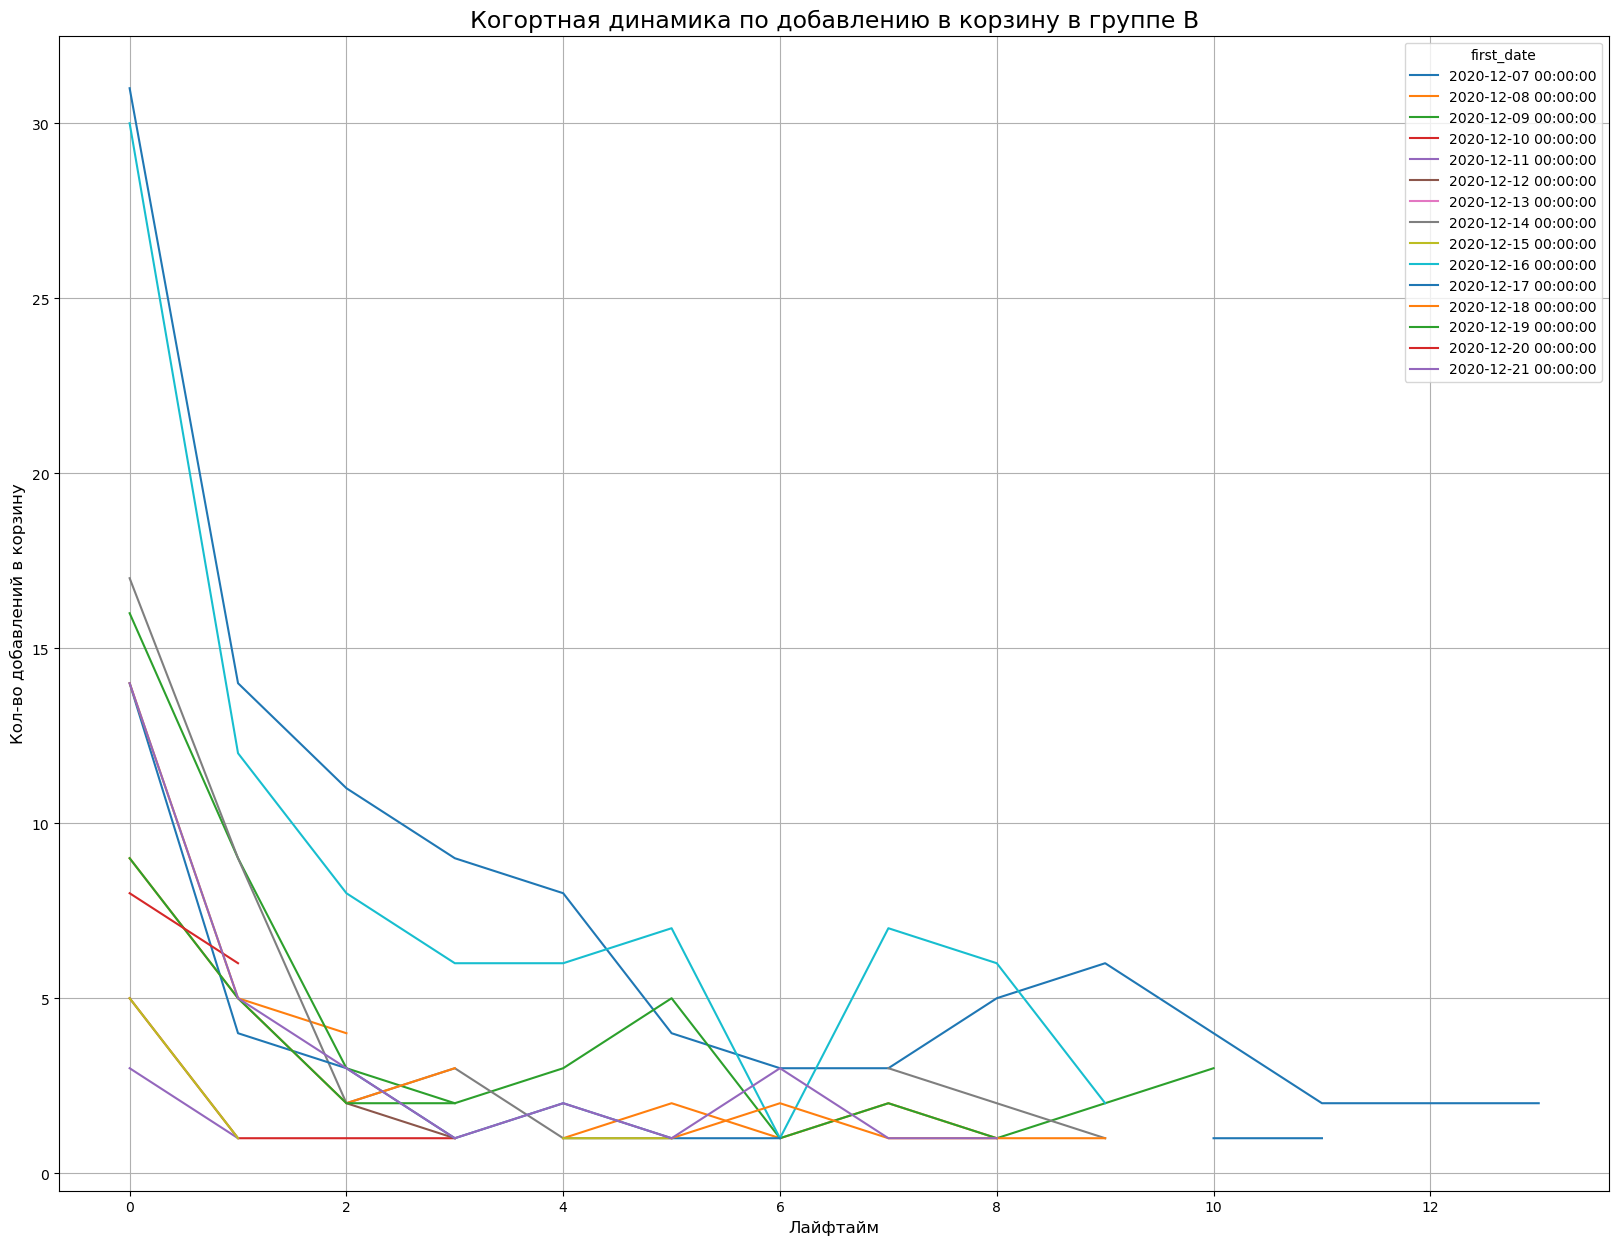

In [51]:
# визуализируем когортную динамику по добавлению в корзину в группе В
(sample_b
 .query('event_name == "product_cart"')
 .pivot_table(
     index='lifetime', 
     columns='first_date', 
     values='user_id', 
     aggfunc='count')
 .plot(grid=True, figsize=(20,15))
)
plt.xlabel('Лайфтайм', size=12)
plt.ylabel('Кол-во добавлений в корзину', size=12)
plt.title('Когортная динамика по добавлению в корзину в группе В', size=17)
plt.show()

Видим, что на седьмой день большая часть когорт сводится к минимальным значениям. Вероятно, в этот день были технические сбои.  
Единственная когорта, прожившая все четырнадцать дней - 17 декабря, она же лидер по добавлениям в корзину.  
Общая картина - спад активности в первые три дня и непредсказуемая активность в последующие - какие-то когорты проявляют активность и даже усиливают её (19 декабря), а какие-то вовсе пропадают (10 декабря) 

**Проанализируем покупки в каждой группе:**

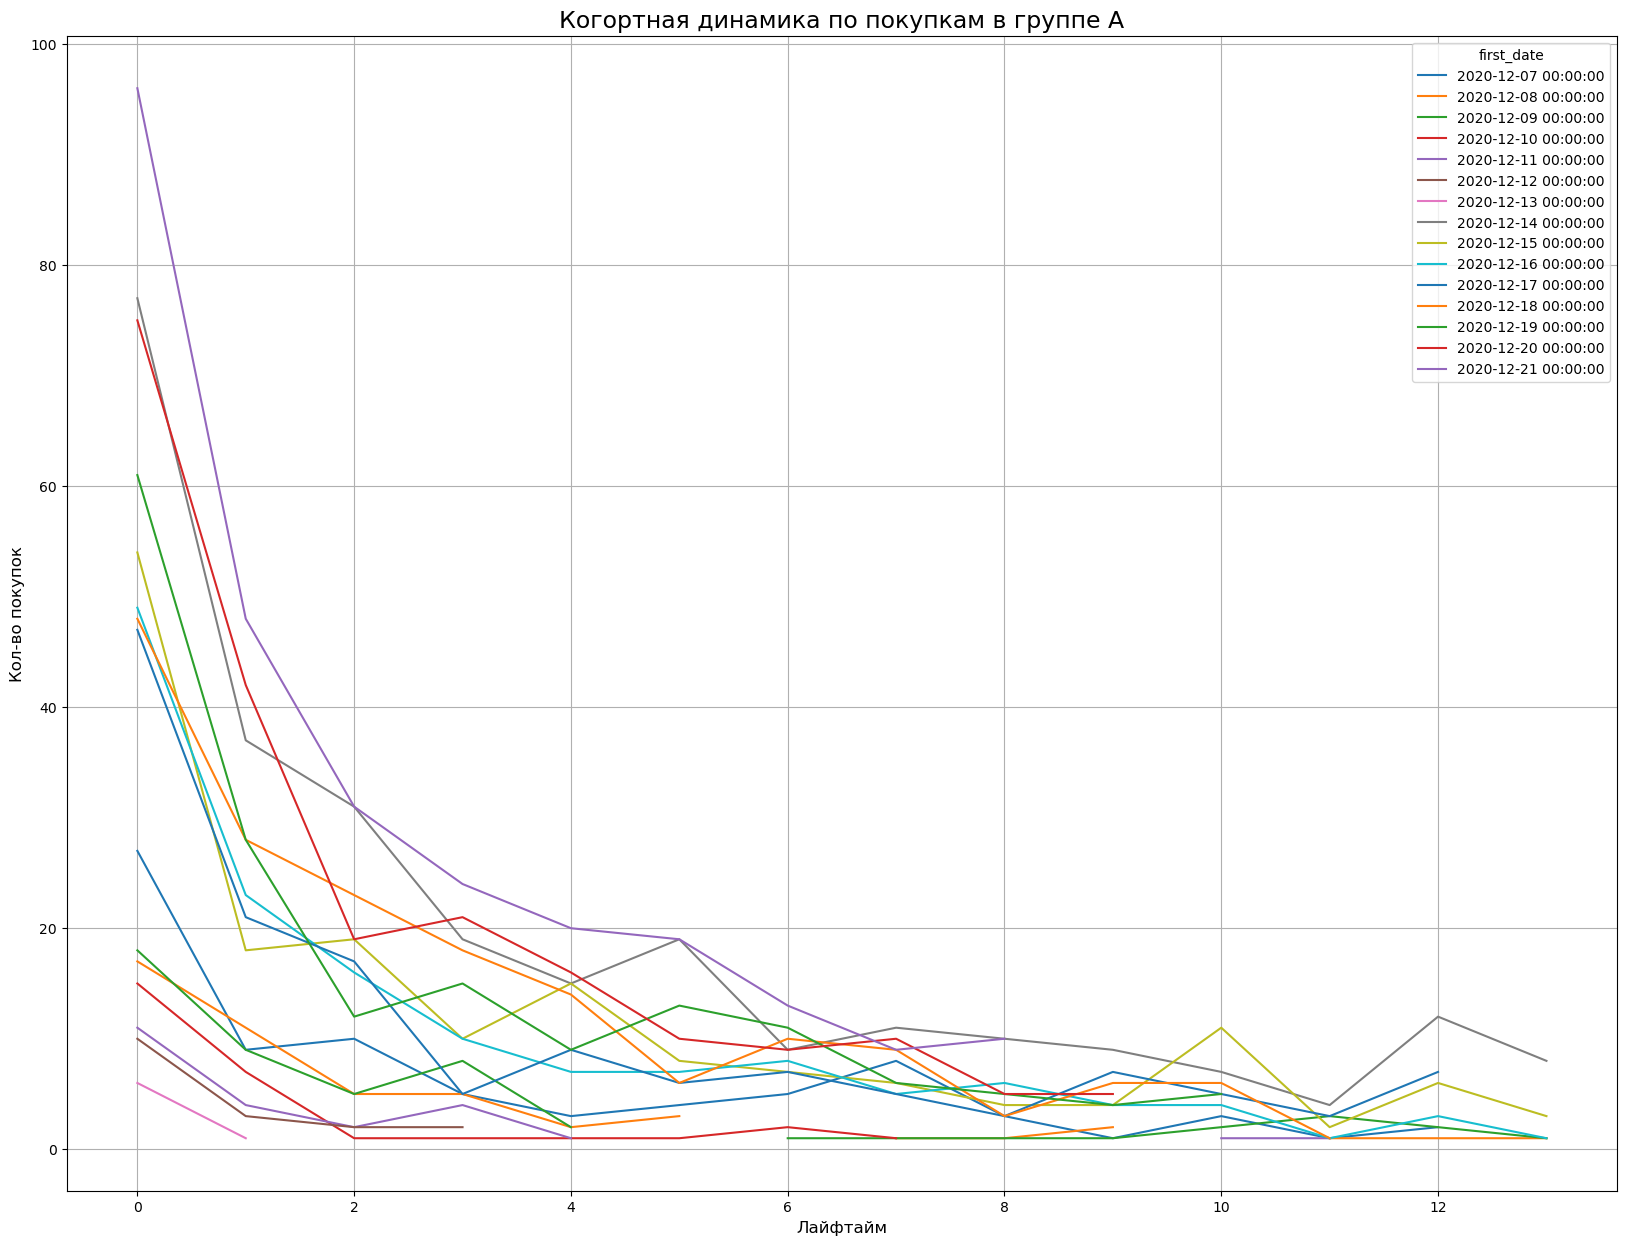

In [52]:
# визуализируем когортную динамику по покупкам в группе А
(sample_a
 .query('event_name == "purchase"')
 .pivot_table(
     index='lifetime', 
     columns='first_date', 
     values='user_id', 
     aggfunc='count')
 .plot(grid=True, figsize=(20,15))
)
plt.xlabel('Лайфтайм', size=12)
plt.ylabel('Кол-во покупок', size=12)
plt.title('Когортная динамика по покупкам в группе А', size=17)
plt.show()

В группе А динамика покупок имеет несколько тенденций:
- число покупок резко падает в первые три дня, чем больше покупок в когорте - тем активнее падение 
- самая активная когорта в первые лайфтаймы - 21 декабря, самая активная в последние лайфтаймы - 14 декабря
- все когорты имеют возрастание числа покупок - в разные дни лайфтайма. Наиболее высокие у когорт 14 и 15 декабря 
- у некоторых когорт есть дни без покупок 
- доживают до четырнадцатого дня только треть когорт, с минимальными значениями активности

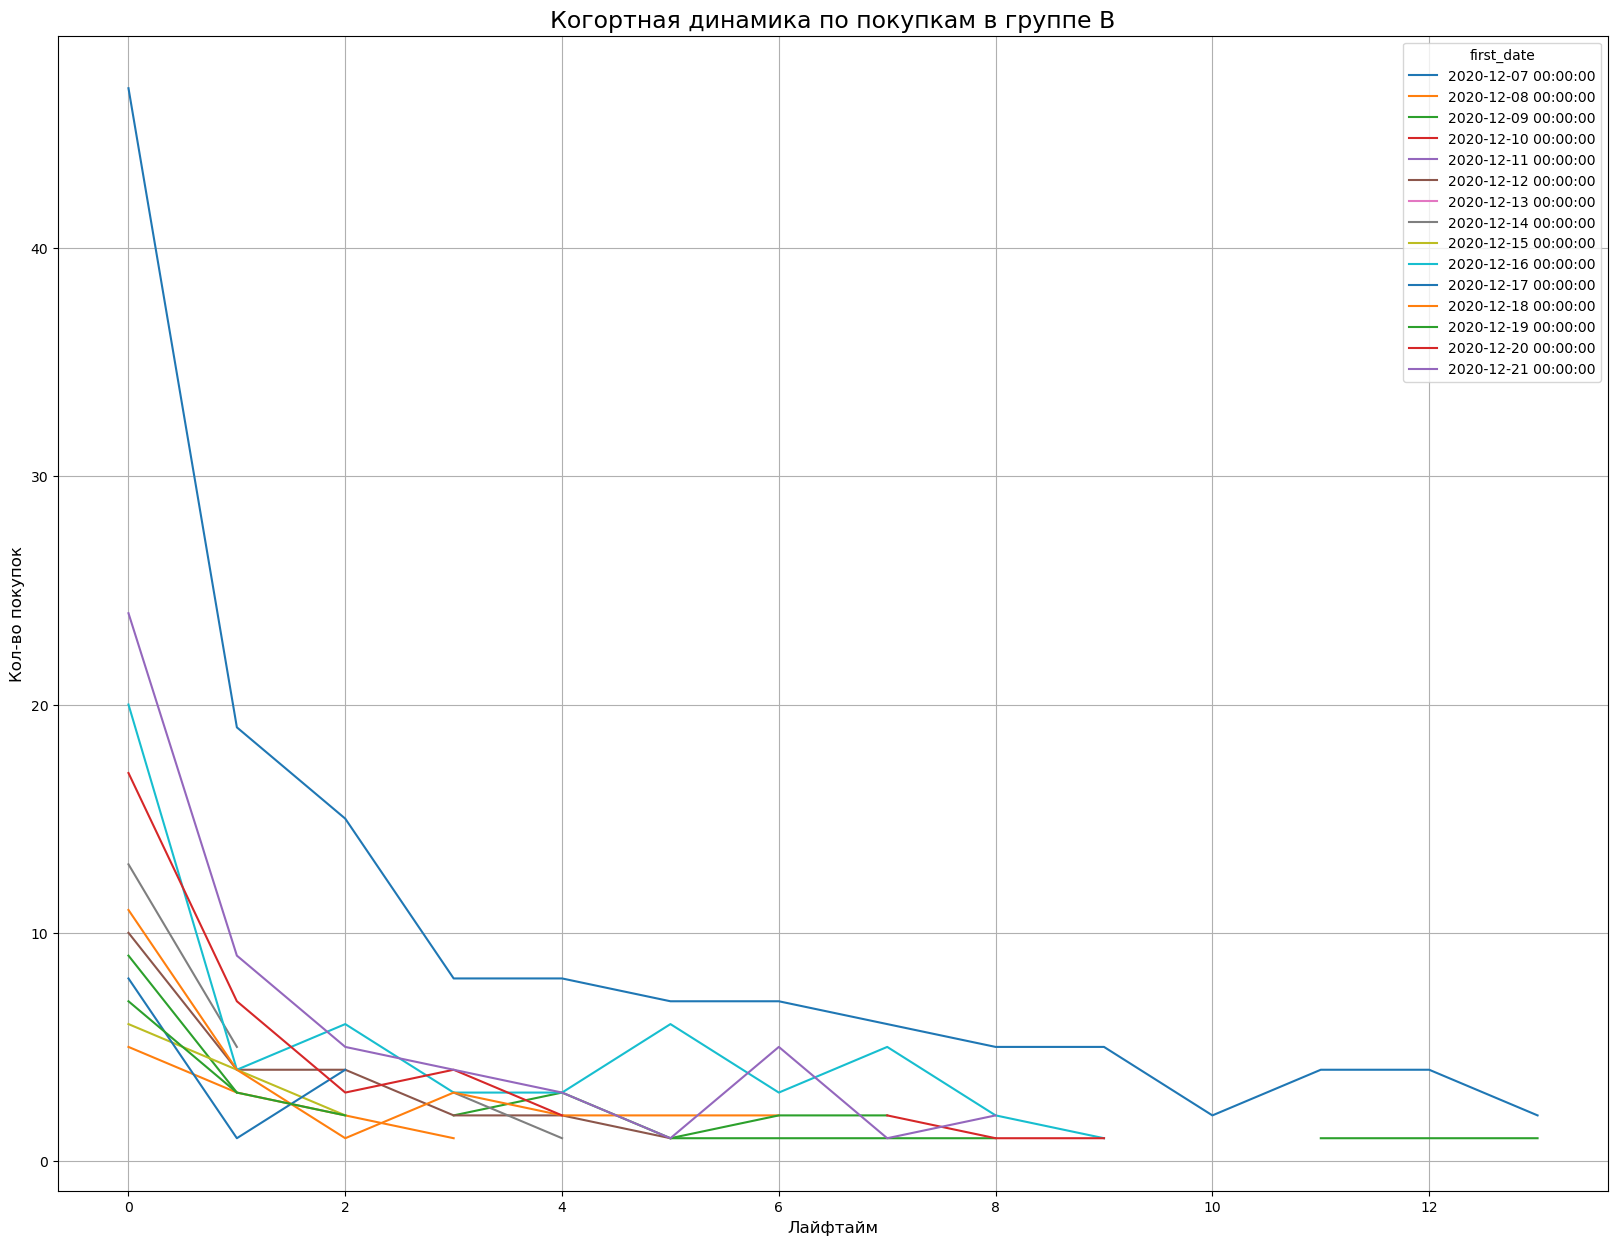

In [53]:
# визуализируем когортную динамику по покупкам в группе В
(sample_b
 .query('event_name == "purchase"')
 .pivot_table(
     index='lifetime', 
     columns='first_date', 
     values='user_id', 
     aggfunc='count')
 .plot(grid=True, figsize=(20,15))
)
plt.xlabel('Лайфтайм', size=12)
plt.ylabel('Кол-во покупок', size=12)
plt.title('Когортная динамика по покупкам в группе В', size=17)
plt.show()

Явно лидирует когорта 17 декабря. Она же одна из двух доходит до четырнадцатого дня.  
Большая часть когорт полностью теряет активность на пятый день, далее - активность держится еще пять дней и после пропадает совсем.  

Исходя из исследовательского анализа, <font color='red'>*ожидаемый эффект улучшения каждой метрики на 10% - не достигнут*<font> 
    
В группах А и В ни одно событие не показало положительного прироста по количеству и не позднее четырнадцати дней. 

### Воронка событий

In [54]:
# объявляем маркетинговую воронку
funnel = (
    rst_users
    .pivot_table(index='event_name', 
                 columns='group', 
                 values='user_id', 
                 aggfunc='nunique',
                 margins=True)
)

funnel = (
    funnel
    .sort_values(by='All', ascending=False)
    .reset_index()
)
funnel

group    event_name     A    B   All
0               All  1939  655  2594
1             login  1939  654  2593
2      product_page  1265  367  1632
3          purchase   613  191   804
4      product_cart   589  184   773

Из таблицы видно, что хронология событий нарушена.   

Больше всего значений у регистрации, это событие будем считать первым. Далее следует просмотр страницы товара, затем есть  числовые разногласия - событий покупки больше, чем добавлении в корзину. Вероятно, есть возможность экспресс-покупки без оформления стандартного заказа.   
Учитывая, что покупка является ключевой метрикой, поставим её последним шагом и будем считать, что <font color='red'>*воронка непоследовательна*.<font>  

Конверсию из добавления в корзину к покупке считать некорректной. 

Изменим порядок событий для правильной визуализации:

In [55]:
# редактируем маркетинговую воронку
funnel = (
    funnel
    .reindex([0,1,2,4,3])
    .reset_index(drop=True)
)

funnel['conversion_A'] =  round(funnel['A'].pct_change() + 1, 2) * 100
funnel['conversion_B'] =  round(funnel['B'].pct_change() + 1, 2) * 100
funnel

group    event_name     A    B   All  conversion_A  conversion_B
0               All  1939  655  2594           NaN           NaN
1             login  1939  654  2593         100.0         100.0
2      product_page  1265  367  1632          65.0          56.0
3      product_cart   589  184   773          47.0          50.0
4          purchase   613  191   804         104.0         104.0

**Шаг конверсии в группе А**:
- 65% переходят после регистрации на страницу заказа (лидер)
- 46% добавляют товар в корзину
- *совершают покупку 613 из 1265* = 48%

**Шаг конверсии в группе В**:
- 56% переходят после регистрации на страницу заказа
- 49% добавляют товар в корзину (лидер)
- *совершают покупку 191 из 367* = 50% (лидер)

<font color='red'>*Таким образом, шаг конверсии в покупку выше в экспериментальной группе.*<font>

In [56]:
# визуализируем воронку
funnel_fig = funnel[1:]

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = funnel_fig['event_name'],
    x = funnel_fig['A'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = funnel_fig['event_name'],
    x = funnel_fig['B'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(
    xaxis_title="Всего пользователей",
    yaxis_title="Событие",
    legend_title="Группа",
    title='Воронка событий')

fig.show()

В контрольной группе до покупки доходит 32% пользователей, в новой - 28%.   
При этом конверсия в покупку с предыдущего шага в новой группе несколько выше.

## A/B тест

Посмотрим, как распределены события в каждой группе:

In [57]:
# смотрим количество событий по датам
fig = px.histogram(sample_a['event_dt'], 
                  title='Распределение событий по датам в группе А')

fig.update_layout(
    xaxis_title='Количество событий',
    yaxis_title='Событие')

fig.show()

Из графика видим, что основной пик событий в группе А был 21 декабря с 12:00 до 00:00 и составил свыше 500 событий.  
14 декабря виден резкий всплеск активности, которая продержится до 24 декабря.

In [58]:
# смотрим количество событий по датам
fig = px.histogram(sample_b['event_dt'], 
                  title='Распределение событий по датам в группе B')

fig.update_layout(
    xaxis_title='Количество событий',
    yaxis_title='Событие')

fig.show()

В группе В ситуация схожа - пик пришёлся на период с 6:00 20 декабря по 18:00 21 декабря (почти 200 событий).  
Однако есть различие с группой А - на начало наблюдений (7 декабря) активность в новой платёжной воронке сопоставима с пиковыми значениями и колеблется на протяжении всего времени не так сильно, как в контрольной группе.   
После 24 декабря наблюдается резкий спад активности.

Приступим к тестированию.   
Тест будем проводить, применив z-критерий Фишера, поскольку проверяться будут пропорции пользователей, совершивших каждое событие, между группами А и В.

Сформулируем гипотезы:  

**Нулевая гипотеза** - нет статистически значимой разницы между долями пользователей, совершивших каждое событие.  
**Альтернативная гипотеза** - есть статистически значимая разница между долями пользователей, совершивших каждое событие.

In [59]:
# задаем пороговое значение
alpha = .05

Поскольку у нас 2 группы и 4 события в каждой, всего будет проведено 8 сравнений.  
Чтобы снизить вероятность ошибки первого рода (ложнопозитивный результат) при множественном сравнении - воспользуемся поправкой Бонферрони:

In [60]:
# объявляем поправку бонферрони
bonferroni = alpha / 8

In [61]:
# объявляем функцию для подсчета статистической значимости
def stat (one, two):
    
    for i in range(1, len(funnel['event_name'])):
        
        success = np.array([funnel.loc[i, one], funnel.loc[i, two]])
        trials = np.array([funnel.loc[0, one], funnel.loc[0, two]]) 
    
        p1 = success[0]/trials[0]
        p2 = success[1]/trials[1]
    
        p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
 
        diff = p1 - p2
    
        z_value = diff / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
        distr = st.norm(0,1)
    
        p_value = (1 - distr.cdf(abs(z_value))) * 2
    
        print(funnel.loc[i, 'event_name'])
        
        print('Значение p_value: ', round(p_value, 3))
        
        if p_value < bonferroni:
            print('Отвергаем нулевую гипотезу, между долями есть статистически значимая разница')
        else:
            print('Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
            
        print(' ')    
    
    return

In [62]:
# проводим тест
stat('A', 'B')

login
Значение p_value:  0.085
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
product_page
Значение p_value:  0.0
Отвергаем нулевую гипотезу, между долями есть статистически значимая разница
 
product_cart
Значение p_value:  0.269
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
purchase
Значение p_value:  0.24
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


<font color='red'>*Выявлена статистически значимая разница между долями пользователей в группах А и В по просмотру страницы товара.* <font>

Доли пользователей в группах А и В по событиям авторизации, добавлении в корзину и покупках не считаются статистически различными.

## Вывод и рекомендации

Мы исследовали результаты проведения теста `recommender_system_test` и выяснили: 

1. *При пребодработке данных*:

- обнаружили пропуски в столбце "детали", которые касались всех шагов воронки, кроме покупки - в этом столбце была указана стоимость заказа
- выявлены пользователи, которые зарегистрировались позднее 21 декабря и согласно технического задания, были удалены из анализа 
- в данных был конкурирующий тест, в который попало 1602 пользователя из `recommender_system_test`. Дублирующихся пользователей было решено удалить, чтобы избежать влияния на результаты интересующего теста
- попавших в обе группы теста не обнаружено
- события, которые превышали срок в 14 дней со дня регистрации, были исключены
- всего в тест было отобрано 2594 пользователя, значительно меньше технического задания (ожидалось свыше 6000)
- также меньше процент - 6% новых европейских пользователей вместо ожидаемых 15%
- есть пересечение с рождественской маркетинговой кампаний в период с 25 декабря по 3 января

2. *Исследовательский анализ показал*:

- неравномерное распределение в группах: А - 75%,  В - 25%
- в группе А событий больше, в среднем 6.8, чаще 6. группа В отстает со средним 5.4 и модой в 4 события
- *общая динамика по событиям в группе А*:  
   - пик 21 декабря
   - основная активность с 14 по 21 декабря
   - активнее всех *когорты 14 декабря* (лидирует по добавлению в корзину) и *21 декабря* (просмотр страниц и покупка)
   - все события показали отрицательную тенденцию к 14-му дню
- *общая динамика по событиям в группе В*:  
   - интенсивная динамика с 7 по 21 декабря
   - по всем событиям лидирует *когорта 17 декабря*   
   - все события показали отрицательную динамику к 14-му дню
- воронка событий выстраивалась непоследовательно в обеих группах:
    > регистрация
    >> просмотр товара  >> покупка 
    >>> добавление в корзину >> покупка
    
3. *Статистический анализ*:

- сформулирована гипотеза о том, что нет статистически значимой разницы между долями пользователей, совершивших каждое событие между группами А и В, <font color='red'>*обнаружена статистически значимая разница между долями пользователей по просмотру страницы товара.* <font>    
- Исходя из исследовательского анализа, <font color='red'>*конверсия на этом шаге хуже у экспериментальной группы.*<font>

По остальным событиям статистически значимой разницы выявлено не было.


4. *Рекомендации*:

Cтоит признать тест некорректным и провести заново, соблюдая техническое задание.
Также стоит обратить особое внимание на шаг конверсии от регистрации к просмотру страницы товара - здесь экспериментальная группа показала значения ниже.